<!-- ![Telecom Churn Prediction]() -->

# **Churn Prediction Project**

**Author Name**: Danish Javaid Meo \
**Email**: danishjmeo@gmail.com\
**LinkedIn**: [link](https://www.linkedin.com/in/danish-javaid-4271a8231)\
**Kaggle**: [link](https://www.kaggle.com/danishjmeo)

# Import Libraries

In [1]:
# Import Libraries

# Basic Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import pickle


# Generate Mock Customer Data

In [2]:
# Generate mock customer data

np.random.seed(42)   # It guarantees that others will get the exact same random values when running your code.

num_customers = 2000  # Number of customers



data = {

    'CustomerID': [f'CUST{1000+i}' for i in range(num_customers)],    # This ensures every customer gets a unique ID, starting from CUST1000 in col CustomerID

    'Gender': np.random.choice(['Male', 'Female'], num_customers, p=[0.5, 0.5]),   # Gender column will contain 50% Male and 50% Female entries choosen randomly

    'SeniorCitizen': np.random.choice([0, 1], num_customers, p=[0.84, 0.16]),   #Each customer is randomly marked as senior (1) or not (0) with the chances of about 16% seniors and 84% non-seniors.

    'Partner': np.random.choice(['Yes', 'No'], num_customers, p=[0.48, 0.52]), # this assign whether the customer has a partner(48%) or not(52%) 

    'Dependents': np.random.choice(['Yes', 'No'], num_customers, p=[0.3, 0.7]), # Dependent radnomly assign to 30% of customers and 70% of customers don't have dependents

    'Tenure': np.random.randint(1, 73, num_customers), # Months

    'PhoneService': np.random.choice(['Yes', 'No'], num_customers, p=[0.9, 0.1]), #  Generates 90% of customers have phone service and 10% don't  randomly
    
    # Simillary the data for the rest of the columns each with their respective probabilities assigned to them

    'MultipleLines': np.random.choice(['Yes', 'No', 'No phone service'], num_customers, p=[0.42, 0.48, 0.1]),

    'InternetService': np.random.choice(['DSL', 'Fiber optic', 'No'], num_customers, p=[0.34, 0.44, 0.22]),

    'OnlineSecurity': np.random.choice(['Yes', 'No', 'No internet service'], num_customers, p=[0.28, 0.50, 0.22]),

    'OnlineBackup': np.random.choice(['Yes', 'No', 'No internet service'], num_customers, p=[0.34, 0.44, 0.22]),

    'DeviceProtection': np.random.choice(['Yes', 'No', 'No internet service'], num_customers, p=[0.34, 0.44, 0.22]),

    'TechSupport': np.random.choice(['Yes', 'No', 'No internet service'], num_customers, p=[0.29, 0.49, 0.22]),

    'StreamingTV': np.random.choice(['Yes', 'No', 'No internet service'], num_customers, p=[0.38, 0.40, 0.22]),

    'StreamingMovies': np.random.choice(['Yes', 'No', 'No internet service'], num_customers, p=[0.39, 0.39, 0.22]),

    'Contract': np.random.choice(['Month-to-month', 'One year', 'Two year'], num_customers, p=[0.55, 0.24, 0.21]),

    'PaperlessBilling': np.random.choice(['Yes', 'No'], num_customers, p=[0.59, 0.41]),

    'PaymentMethod': np.random.choice(['Electronic check', 'Mailed check', 'Bank transfer (automatic)', 'Credit card (automatic)'], num_customers, p=[0.34, 0.23, 0.22, 0.21]),

    'MonthlyCharges': np.random.normal(loc=65, scale=30, size=num_customers).clip(18, 120).round(2),

}

df_customers = pd.DataFrame(data)


# This code snippet, when run, will generate telecom_churn_mock_data.csv.


In [3]:

# Generate TotalCharges based on Tenure and MonthlyCharges with some noise

df_customers['TotalCharges'] = (df_customers['Tenure'] * df_customers['MonthlyCharges'] * np.random.uniform(0.95, 1.05, num_customers)).round(2)



# # Make some TotalCharges empty for realism (e.g., new customers with 0 tenure)
df_customers.loc[df_customers['Tenure'] == 1, 'TotalCharges'] = df_customers['MonthlyCharges']

# Introduce NaNs randomly for customers with tenure < 3
random_indices = np.random.choice(df_customers.index, size=int(num_customers * 0.01), replace=False)
condition = df_customers.index.isin(random_indices) & (df_customers['Tenure'] < 3)
df_customers.loc[condition, 'TotalCharges'] = np.nan

# Simulate Churn (more likely for month-to-month, high charges, low tenure)
churn_probability = (
    0.1
    + 0.15 * (df_customers['Contract'] == 'Month-to-month')
    + 0.1 * (df_customers['InternetService'] == 'Fiber optic')
    + 0.001 * (df_customers['MonthlyCharges'] - 65)
    - 0.002 * (df_customers['Tenure'] - 36)
    + 0.1 * (df_customers['OnlineSecurity'] == 'No')
    + 0.1 * (df_customers['TechSupport'] == 'No')
)

churn_probability = np.clip(churn_probability, 0.01, 0.99)
df_customers['Churn'] = np.random.binomial(1, churn_probability, num_customers).astype(str)
df_customers['Churn'] = df_customers['Churn'].replace({'1': 'Yes', '0': 'No'})


# Replace 'No phone service' and 'No internet service' for consistency

for col in ['MultipleLines']:

    df_customers[col] = df_customers.apply(lambda row: 'No' if row['PhoneService'] == 'No' else row[col], axis=1)



for col in ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']:

    df_customers[col] = df_customers.apply(lambda row: 'No' if row['InternetService'] == 'No' else row[col], axis=1)

# Save to CSV

df_customers.to_csv('telecom_churn_mock_data.csv', index=False)
 
print("Mock telecom churn data generated: telecom_churn_mock_data.csv")

print(df_customers.head())

print(f"\nChurn distribution:\n{df_customers['Churn'].value_counts(normalize=True)}")



# This code snippet, when run, will generate telecom_churn_mock_data.csv.


Mock telecom churn data generated: telecom_churn_mock_data.csv
  CustomerID  Gender  SeniorCitizen Partner Dependents  Tenure PhoneService  \
0   CUST1000    Male              0      No         No      30          Yes   
1   CUST1001  Female              0      No        Yes      11          Yes   
2   CUST1002  Female              1      No         No      17           No   
3   CUST1003  Female              0     Yes         No      26          Yes   
4   CUST1004    Male              0     Yes        Yes      23          Yes   

  MultipleLines InternetService       OnlineSecurity  ... DeviceProtection  \
0           Yes              No                   No  ...               No   
1           Yes     Fiber optic  No internet service  ...               No   
2            No     Fiber optic                   No  ...               No   
3            No              No                   No  ...               No   
4            No     Fiber optic  No internet service  ...               

# **Data Understanding & EDA**

In [4]:
# shape of generated data
df_customers.shape

(2000, 21)

In [5]:
# Check Basic Statistical Properties
df_customers.describe()

,SeniorCitizen,Tenure,MonthlyCharges,TotalCharges
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.151500,36.342500,65.880710,2394.132725
std,0.358625,21.029392,27.154716,1807.861046
min,0.000000,1.000000,18.000000,18.000000
25%,0.000000,18.000000,45.342500,934.712500
50%,0.000000,37.000000,65.460000,1972.770000
75%,0.000000,54.000000,84.992500,3532.675000
max,1.000000,72.000000,120.000000,8756.020000


In [6]:
df_customers['Tenure'].max()

np.int32(72)

# More Information

In [7]:
# Check Missing Values
df_customers.isnull().sum()

CustomerID          0
Gender              0
SeniorCitizen       0
Partner             0
Dependents          0
Tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [8]:
# Check Data Types of Each Column and Memory Usage
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CustomerID        2000 non-null   object 
 1   Gender            2000 non-null   object 
 2   SeniorCitizen     2000 non-null   int64  
 3   Partner           2000 non-null   object 
 4   Dependents        2000 non-null   object 
 5   Tenure            2000 non-null   int32  
 6   PhoneService      2000 non-null   object 
 7   MultipleLines     2000 non-null   object 
 8   InternetService   2000 non-null   object 
 9   OnlineSecurity    2000 non-null   object 
 10  OnlineBackup      2000 non-null   object 
 11  DeviceProtection  2000 non-null   object 
 12  TechSupport       2000 non-null   object 
 13  StreamingTV       2000 non-null   object 
 14  StreamingMovies   2000 non-null   object 
 15  Contract          2000 non-null   object 
 16  PaperlessBilling  2000 non-null   object 


In [9]:
len(df_customers[df_customers['TotalCharges']==" "])

0

# Churn Distribution

In [10]:
df_customers['Churn'].value_counts()

Churn
No     1321
Yes     679
Name: count, dtype: int64

<Axes: title={'center': 'Churn Distribution'}, xlabel='Churn'>

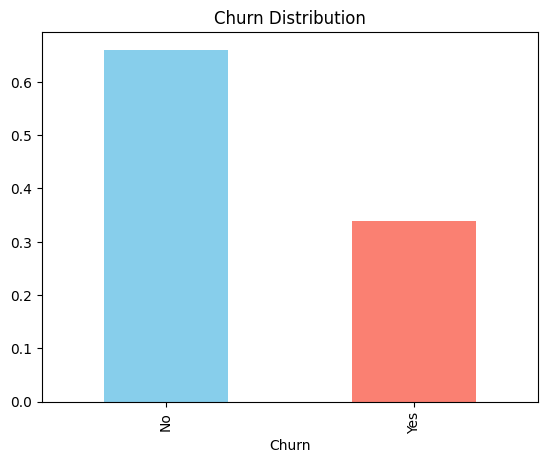

In [11]:
df_customers['Churn'].value_counts(normalize=True).plot(kind='bar', title='Churn Distribution', color=['skyblue', 'salmon'])


# Bar plot for categorical columns

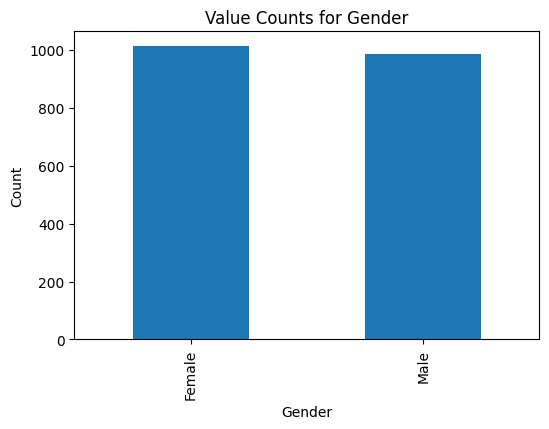

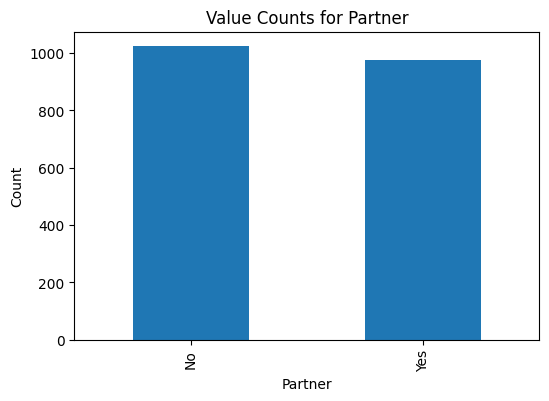

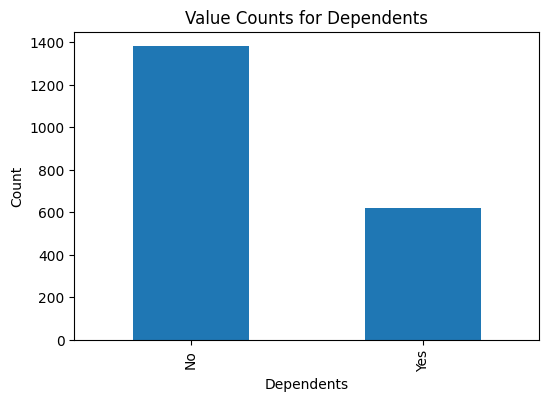

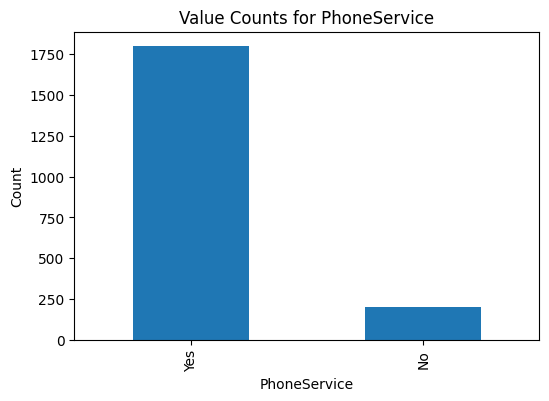

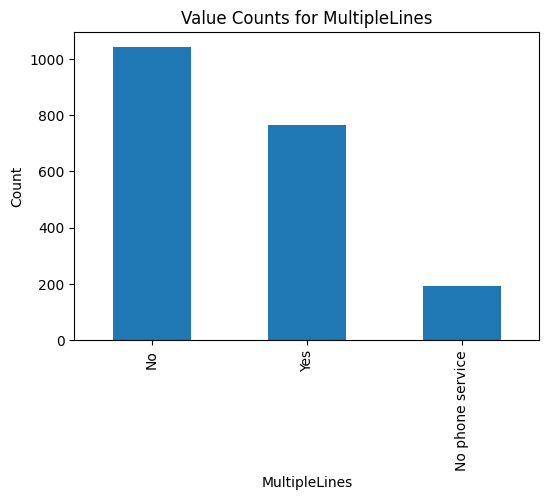

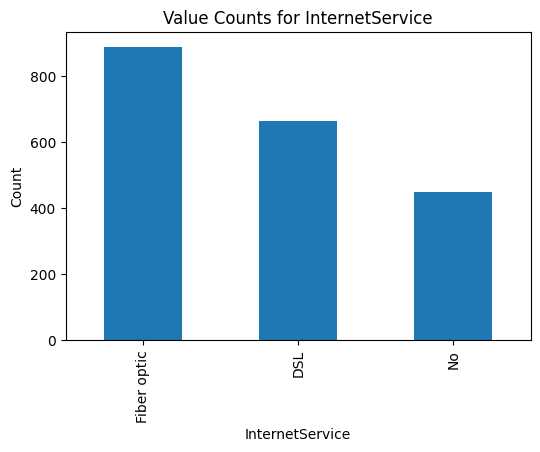

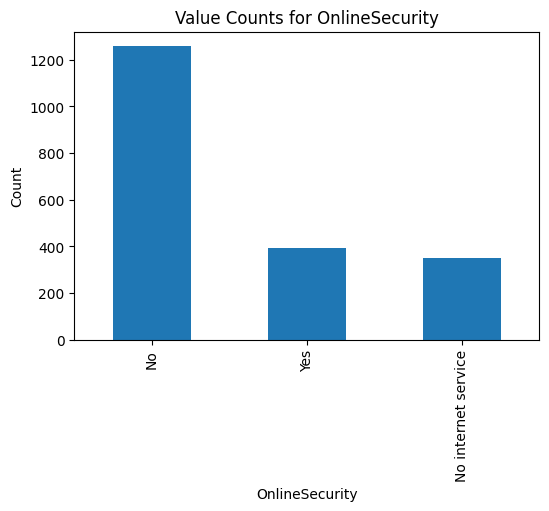

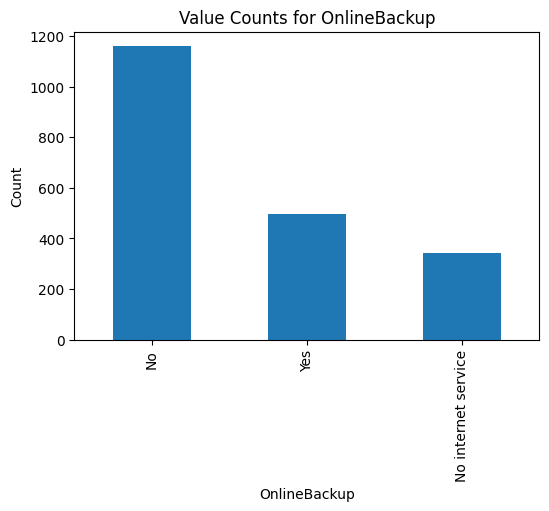

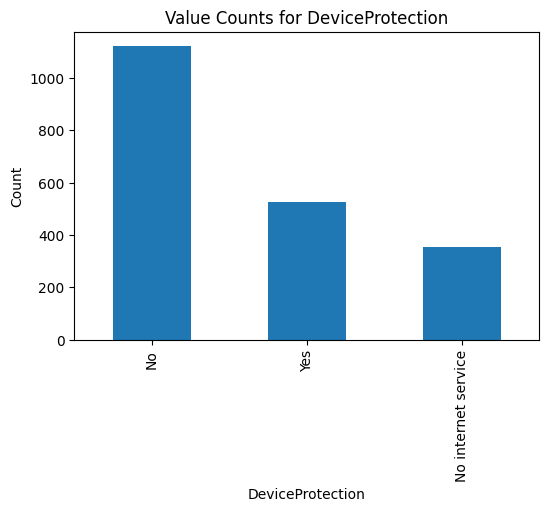

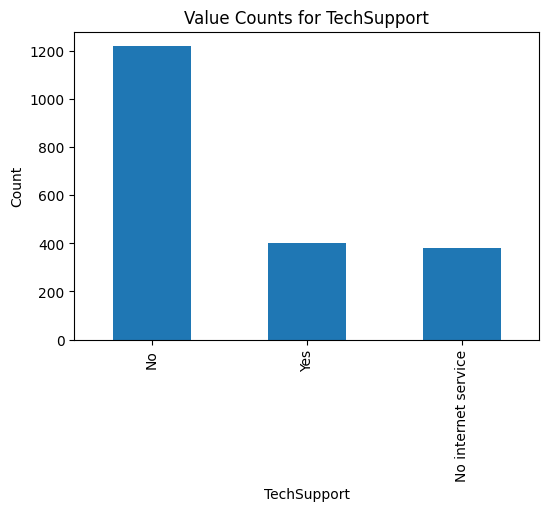

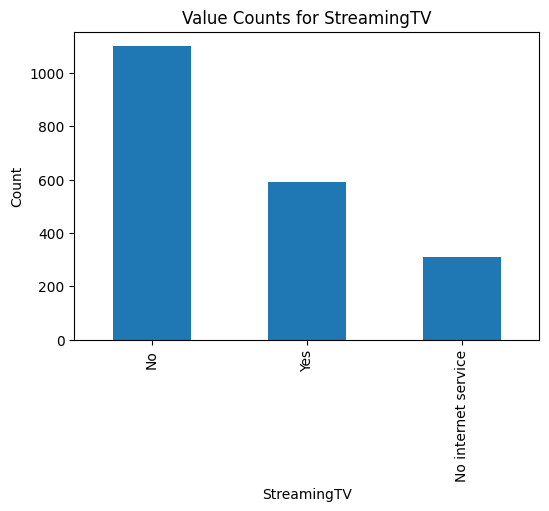

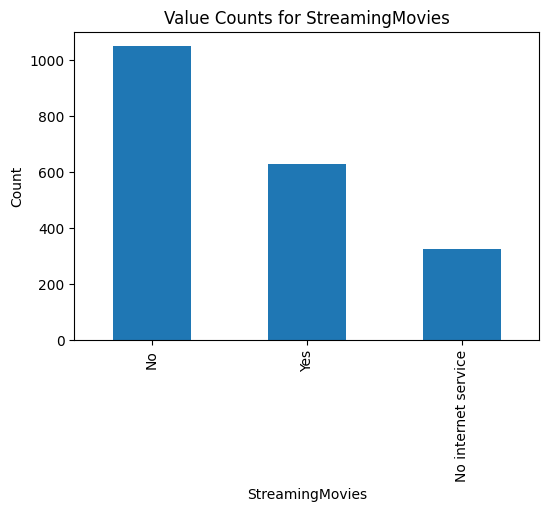

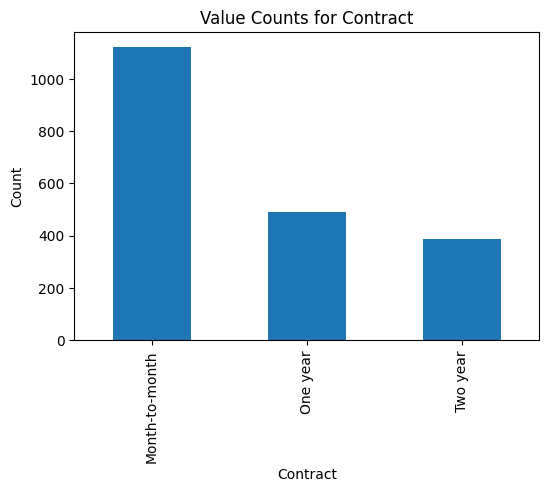

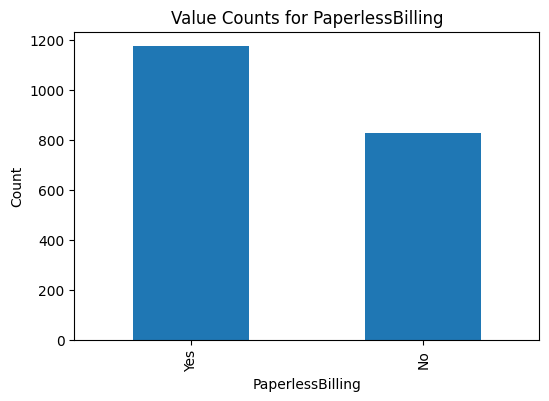

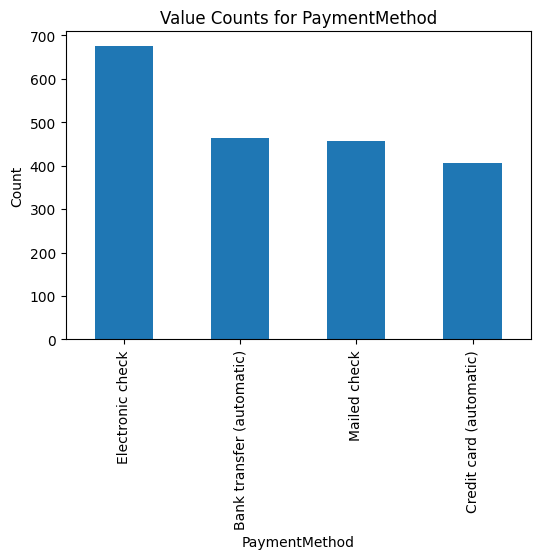

In [12]:

for col in ['Gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity','OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies','Contract', 'PaperlessBilling', 'PaymentMethod']:
    plt.figure(figsize=(6, 4))
    value_counts = df_customers[col].value_counts()
    value_counts.plot(kind='bar')
    plt.title(f'Value Counts for {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()


# Numeric Columns Distribution

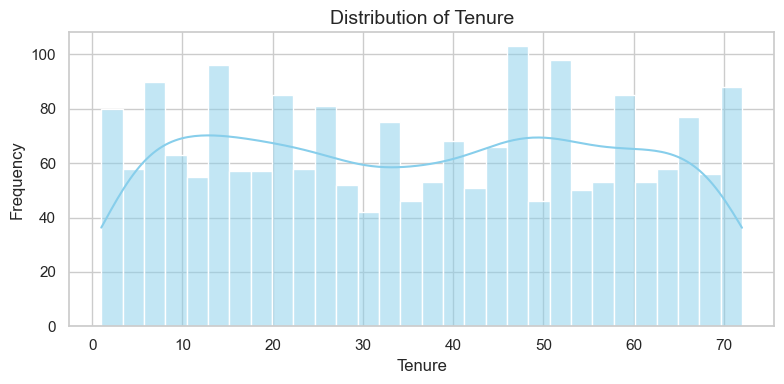

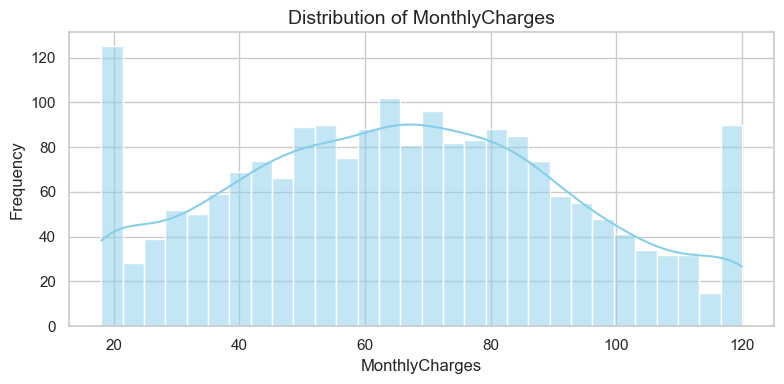

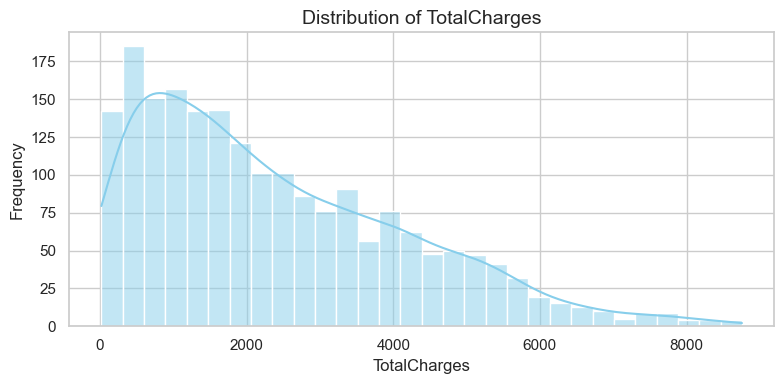

In [13]:

# Numerical columns to plot
num_cols = ['Tenure', 'MonthlyCharges', 'TotalCharges']

# Set the plot style
sns.set(style="whitegrid")

# Plot histograms
for col in num_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(data=df_customers, x=col, kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of {col}', fontsize=14)
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()


# Heat Map

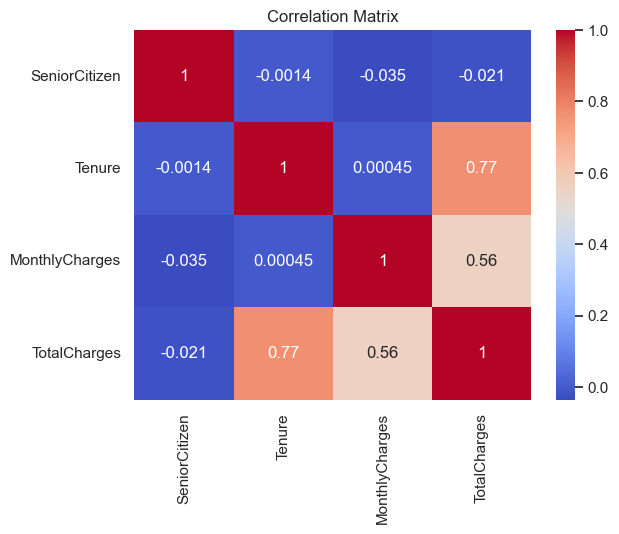

In [14]:
df_corr = df_customers[['SeniorCitizen', 'Tenure', 'MonthlyCharges', 'TotalCharges']].corr()
sns.heatmap(df_corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

# Outliers

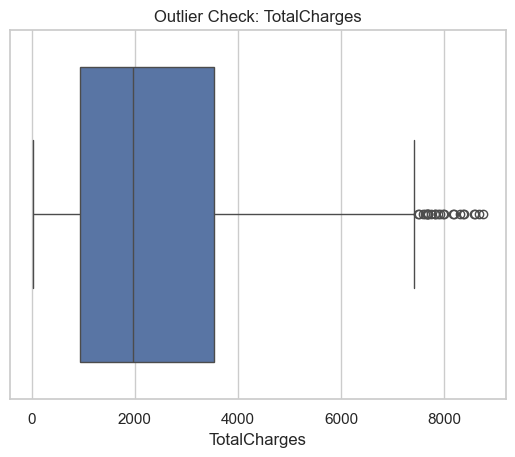

In [15]:
sns.boxplot(x=df_customers['TotalCharges'])
plt.title("Outlier Check: TotalCharges")
plt.show()


In [16]:
def kdeplot(f):
    plt.figure(figsize=(9, 4))
    plt.title(f"KDE for {f}")
    sns.kdeplot(df_customers[df_customers['Churn'] == 'No'][f], color='navy', label='Churn: No')
    sns.kdeplot(df_customers[df_customers['Churn'] == 'Yes'][f], color='orange', label='Churn: Yes')
    plt.legend()
    plt.show()

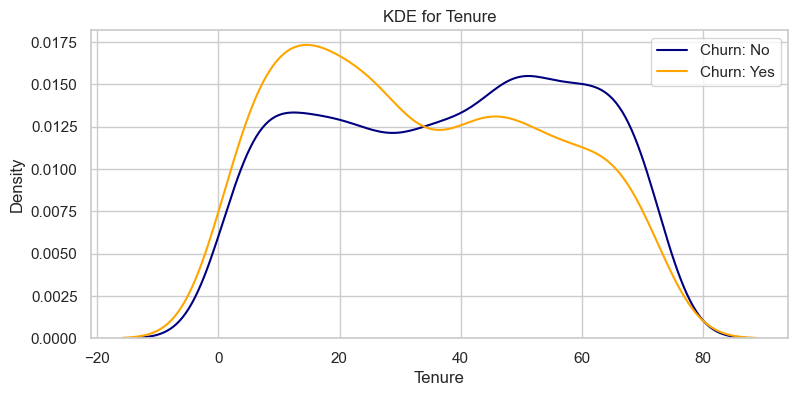

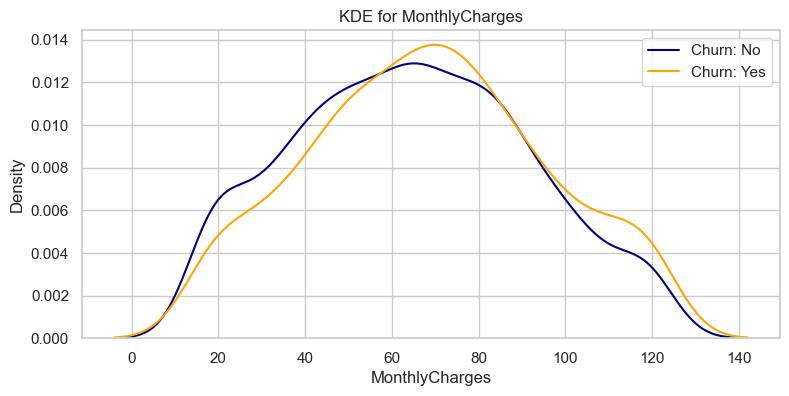

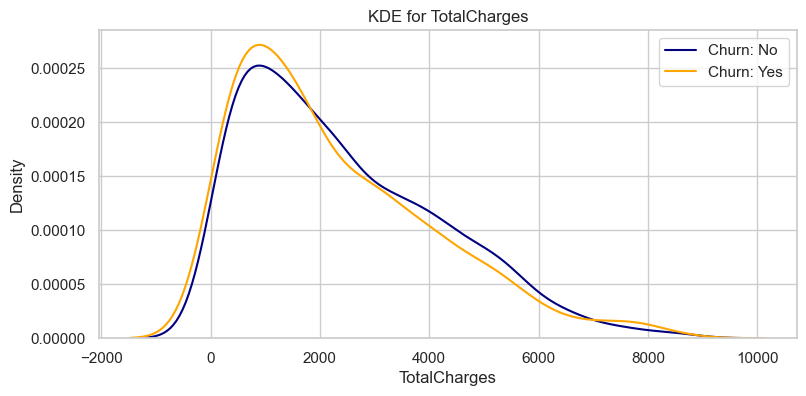

In [17]:
kdeplot('Tenure')
kdeplot('MonthlyCharges')
kdeplot('TotalCharges')

# Internet Service & Churn Relation

<Axes: xlabel='InternetService', ylabel='count'>

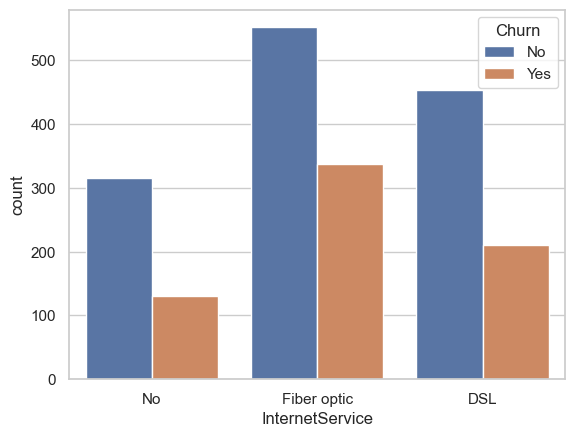

In [18]:
sns.countplot(data=df_customers, x='InternetService', hue='Churn')


#  Is there a link between Payment Method and Churn Behavior?

<Axes: xlabel='PaymentMethod', ylabel='count'>

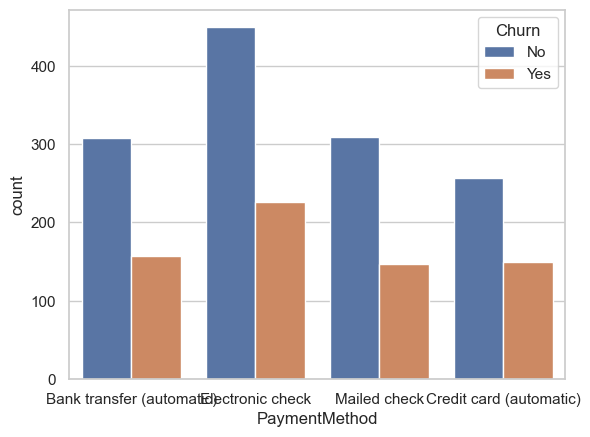

In [19]:
sns.countplot(data=df_customers, x='PaymentMethod', hue='Churn')


#  Do senior citizens churn more than non-senior citizens?

<Axes: xlabel='SeniorCitizen', ylabel='count'>

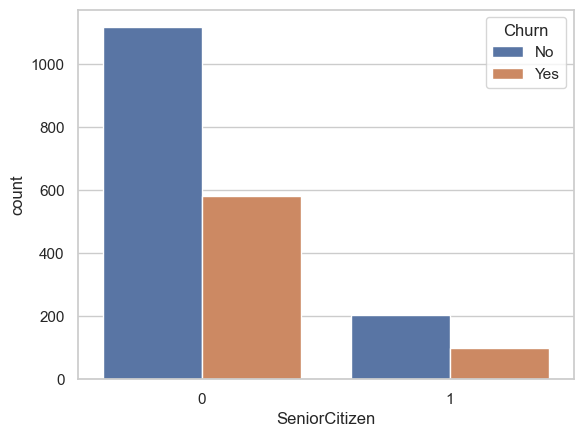

In [20]:
sns.countplot(data=df_customers, x='SeniorCitizen', hue='Churn')


# Do Customers having partners have churn rate?

<Axes: xlabel='Partner', ylabel='count'>

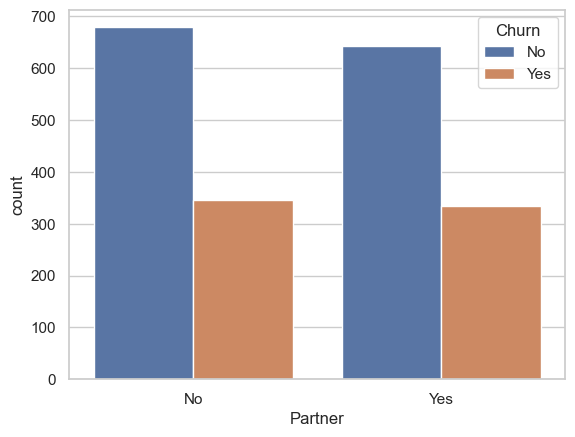

In [21]:
sns.countplot(data=df_customers, x='Partner', hue='Churn')


# Customers with Dependents Vary Across Churn?

<Axes: xlabel='Dependents', ylabel='count'>

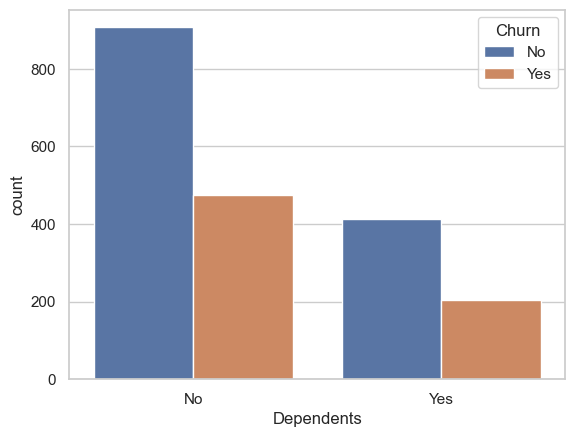

In [22]:
sns.countplot(data=df_customers, x='Dependents', hue='Churn')

#  How does churn vary across contract types?


<Axes: xlabel='Contract', ylabel='count'>

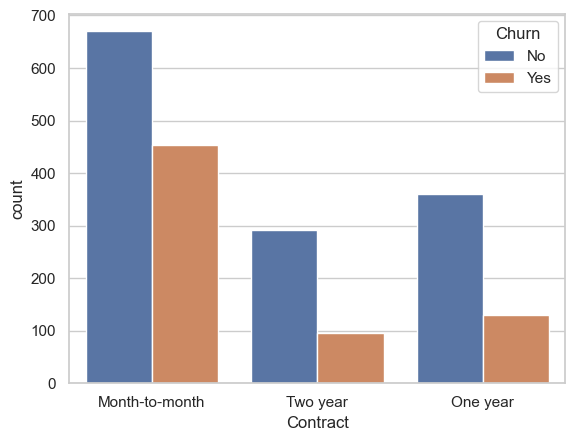

In [23]:
sns.countplot(data=df_customers, x='Contract', hue='Churn')


# Data Preprocessing & Feature Engineering

In [24]:
# Dropping irrelevant Column
df_customers.drop(columns=['CustomerID'], inplace=True)


> Let 's do label Encoding where the column values are binary and if more catgorie we will do one hot encoding

In [25]:
le = LabelEncoder()

# Select categorical columns (dtype 'object') only
cat_cols = df_customers.select_dtypes(include=['object']).columns

for col in cat_cols:
    df_customers[col] = le.fit_transform(df_customers[col].astype(str))


# New Columns

In [26]:

df_customers['TenureYears'] = (df_customers['Tenure'] // 12).astype(int)

df_customers['AvgMonthlyCharge'] = df_customers.apply(
    lambda row: row['TotalCharges'] / row['Tenure'] if row['Tenure'] > 0 else 0,
    axis=1
)


# Scaling Numeric Columns

In [27]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
# Fit and transform the data
df_customers[['MonthlyCharges', 'TotalCharges', 'AvgMonthlyCharge']] = scaler.fit_transform(df_customers[['MonthlyCharges', 'TotalCharges', 'AvgMonthlyCharge']])

# Selecting Relevant Features

In [28]:
X = df_customers.drop(columns='Churn')
y = df_customers['Churn']

# Fit Random Forest model
model = RandomForestClassifier(random_state=42)
model.fit(X, y)

# Get feature importances
importances = model.feature_importances_
features = X.columns

# Create DataFrame of feature importances
feat_imp_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Select top 10 important features
top_features = feat_imp_df['Feature'].head(15).tolist()

# Update df_customers to keep only top features + target
df_customers_selected = df_customers[top_features + ['Churn']]



df_customers_selected.head()


,TotalCharges,AvgMonthlyCharge,MonthlyCharges,Tenure,PaymentMethod,Contract,TenureYears,MultipleLines,TechSupport,OnlineSecurity,InternetService,OnlineBackup,StreamingTV,DeviceProtection,StreamingMovies,Churn
0,0.232205,0.471519,0.505392,30,0,0,2,2,0,0,2,0,0,0,0,0
1,0.057727,0.280218,0.294902,11,2,0,0,2,1,1,1,1,0,0,1,0
2,0.067758,0.173169,0.181961,17,2,2,1,0,0,0,1,2,2,0,0,0
3,0.245051,0.608161,0.605098,26,0,1,2,0,0,0,2,0,0,0,0,0
4,0.189352,0.512898,0.513922,23,3,0,1,0,2,1,1,0,0,0,2,0


# Models 


Training Logistic Regression...
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Training SVC...
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Training Random Forest...
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Training Gradient Boosting...
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Training XGBoost...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\Users\dell\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:52:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Training CatBoost...
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best Model Summary:
                 Model                                        Best Params  \
0  Logistic Regression  {'penalty': 'elasticnet', 'l1_ratio': 0.5, 'fi...   

   Accuracy  Precision    Recall  F1 Score  F1 Score (CV on Test)   ROC AUC  
0     0.585   0.432432  0.705882  0.536313                0.47222  0.645332  


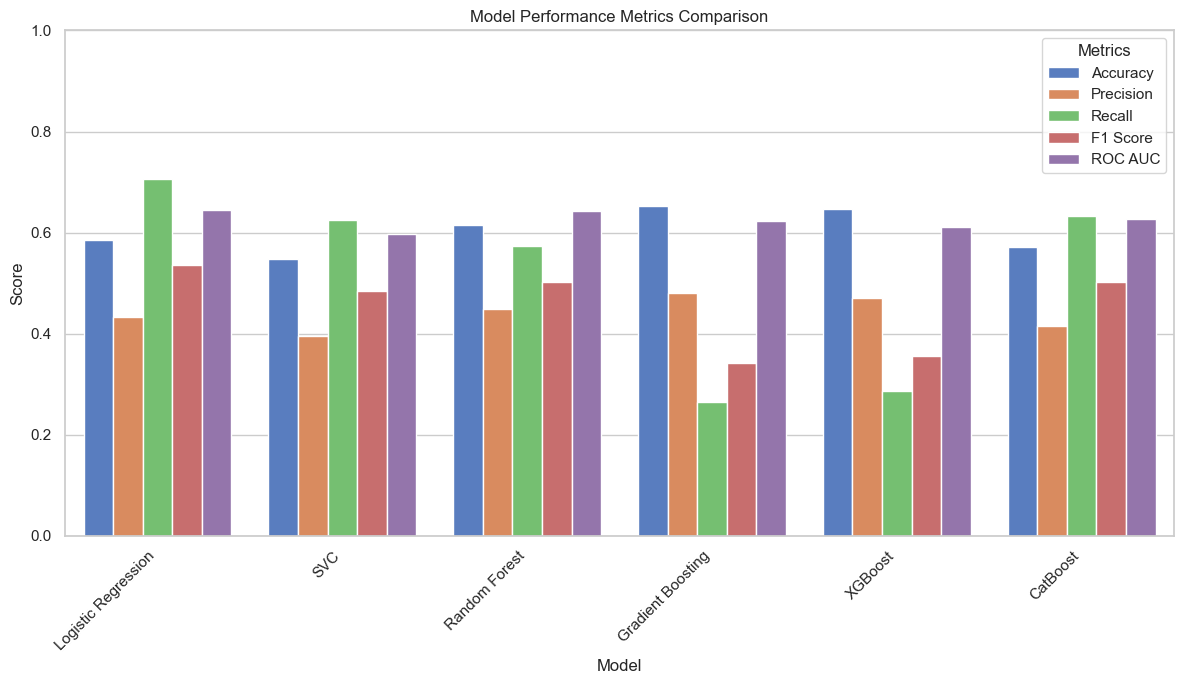

In [29]:
# Target and Features
X = df_customers_selected.drop(columns='Churn')
y = df_customers_selected['Churn']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2,random_state=42, stratify=y
)

# Define stratified k-fold for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define models and their hyperparameter search spaces
models = {
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=5000, class_weight='balanced', solver='saga'),
        "params": [
            {
                "C": [0.001, 0.01, 0.1, 1, 10],
                "penalty": ['l1', 'l2'],
                "fit_intercept": [True, False]
            },
            {
                "C": [0.001, 0.01, 0.1, 1, 10],
                "penalty": ['elasticnet'],
                "fit_intercept": [True, False],
                "l1_ratio": [0, 0.5, 1]
            },
            {
                "C": [0.001, 0.01, 0.1, 1, 10],
                "penalty": [None],
                "fit_intercept": [True, False]
            }
        ]
    },
    "SVC": {
        "model": SVC(probability=True, class_weight='balanced'),
        "params": {
            "C": [0.1, 1, 10],
            "kernel": ['rbf', 'poly'],
            "gamma": ['scale', 'auto'],
            "degree": [3, 4, 5],
            "coef0": [0, 0.1]
        }
    },
    "Random Forest": {
        "model": RandomForestClassifier(class_weight='balanced', random_state=42),
        "params": {
            "n_estimators": [50, 100, 200],
            "max_depth": [5, 7, 10],
            "min_samples_split": [2, 5],
            "min_samples_leaf": [1, 2],
            "max_features": ['sqrt', 'log2', None]
        }
    },
    "Gradient Boosting": {
        "model": GradientBoostingClassifier(random_state=42),
        "params": {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.01, 0.05, 0.1],
            "subsample": [0.6, 0.8, 1.0],
            "max_depth": [3, 5],
            "min_samples_split": [2, 5]
        }
    },
    "XGBoost": {
        "model": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        "params": {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.01, 0.05, 0.1],
            "max_depth": [3, 5, 7],
            "subsample": [0.6, 0.8, 1.0],
            "colsample_bytree": [0.6, 0.8, 1.0]
        }
    },
    "CatBoost": {
        "model": CatBoostClassifier(random_state=42, silent=True, auto_class_weights='Balanced'),
        "params": {
            "iterations": [50, 100, 200],
            "learning_rate": [0.01, 0.05, 0.1],
            "depth": [3, 5, 7],
            "l2_leaf_reg": [1, 3, 5]
        }
    }
}

results = []

for name, config in models.items():
    print(f"\nTraining {name}...")
    clf = RandomizedSearchCV(
        estimator=config["model"],
        param_distributions=config["params"],
        n_iter=10,
        cv=cv,
        scoring='f1',
        n_jobs=-1,
        random_state=42,
        verbose=1
    )
    clf.fit(X_train, y_train)
    best_model = clf.best_estimator_

    # Cross-validated F1 score on test set
    test_f1_scores = cross_val_score(best_model, X_test, y_test, cv=cv, scoring='f1', n_jobs=-1)
    mean_test_f1 = np.mean(test_f1_scores)

    y_pred = best_model.predict(X_test)
    if hasattr(best_model, "predict_proba"):
        y_proba = best_model.predict_proba(X_test)[:, 1]
    else:
        y_proba = [0] * len(y_pred)

    results.append({
        "Model": name,
        "Best Params": clf.best_params_,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred, zero_division=0),
        "F1 Score": f1_score(y_test, y_pred, zero_division=0),
        "F1 Score (CV on Test)": mean_test_f1,
        "ROC AUC": roc_auc_score(y_test, y_proba)
    })

summary = pd.DataFrame(results)
summary_sorted = summary.sort_values(by="F1 Score", ascending=False)

print("\nBest Model Summary:")
print(summary_sorted.head(1))

# Plotting results
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
df_melt = summary.melt(id_vars='Model', value_vars=metrics_to_plot,
                       var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 7))
sns.set(style="whitegrid")

sns.barplot(data=df_melt, x='Model', y='Score', hue='Metric', palette='muted')
plt.title('Model Performance Metrics Comparison')
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Metrics')
plt.tight_layout()
plt.show()

In [30]:

# Find model with highest accuracy
best_result = max(results, key=lambda x: x['Accuracy'])
best_model_name = best_result['Model']

print(f"Best model based on Accuracy: {best_model_name}")

# Get the corresponding best estimator
best_estimator = None

for name, config in models.items():
    if name == best_model_name:
        # Refit the model with best params on full training data
        best_params = [r['Best Params'] for r in results if r['Model'] == name][0]
        model = config['model'].set_params(**best_params)
        best_estimator = model.fit(X_train, y_train)
        break

# Save the model as pickle
with open('best_model_accuracy.pkl', 'wb') as f:
    pickle.dump(best_estimator, f)

print("Best model saved as 'best_model_accuracy.pkl'")


Best model based on Accuracy: Gradient Boosting
Best model saved as 'best_model_accuracy.pkl'


In [31]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,confusion_matrix
# Call the model
model=DecisionTreeClassifier(criterion='entropy',max_depth=7)
model.fit(X_train,y_train)
# Predict the model
y_pred=model.predict(X_test)
# Evaluate the model
accuracy_score(y_test,y_pred)
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))
print(f1_score(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.69      0.83      0.75       264
           1       0.44      0.26      0.33       136

    accuracy                           0.64       400
   macro avg       0.57      0.55      0.54       400
weighted avg       0.60      0.64      0.61       400

[[219  45]
 [100  36]]
0.3317972350230415


In [32]:
# call the model
from sklearn.neighbors import KNeighborsClassifier

model=KNeighborsClassifier(n_neighbors=10,algorithm='kd_tree')

model.fit(X_train,y_train)

y_pred=model.predict(X_test)
# Evaluate the model
accuracy_score(y_test,y_pred)
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))
print(f1_score(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.68      0.91      0.78       264
           1       0.47      0.15      0.23       136

    accuracy                           0.65       400
   macro avg       0.57      0.53      0.50       400
weighted avg       0.60      0.65      0.59       400

[[240  24]
 [115  21]]
0.23204419889502761


----

# **SUMMARY**

- This Notebook Starts with Generating Mock Data for for 2,000 customers.

- `CustomerID` 	Unique IDs like CUST1000, CUST1001...,`Gender`50% Male, 50% Female and more columns some generated using Distributions
- Data has 21 columns and 2000 rows
- float64(2)
- int32(1) 
- int64(1) 
- object(17)

 The target variable Churn was calculated based on a probability model influenced by risk factors such as short tenure, month-to-month contracts, high charges, and lack of online security. After cleaning the dataset (with no null values remaining) and simplifying categorical values, exploratory data analysis revealed that churn was most common among customers with fiber optic internet, short tenure, and month-to-month contracts. Senior citizens and those without tech support also showed higher churn risk.
New features were created, including tenure in years, average monthly charge over tenure .
Categorical columns deals with `Label Encoding`.numrical Columns were scaled using `MinMax scaling`
Multiple models were trained, including `Logistic Regression`, `Random Forest`, `SVC`, `XGBoost`, and `CatBoost`.

After hyperparameter tuning, CatBoost outperformed all others with the best balance of accuracy and generalization. The final model was saved as `best_model_accuracy.pkl`, making this project a complete Snippet of Mock Data Generation, with insights that could help a telecom company reduce churn through targeted retention strategies.

---